
## Data Initializing

In [39]:
import pandas as pd
import numpy as np
import data_handler as dh
import model as md
import time
import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import rc
from multiprocessing import Pool
import pickle
from itertools import permutations
import warnings
warnings.filterwarnings("ignore")

In [40]:
import importlib
importlib.reload(dh)
importlib.reload(md)

<module 'model' from '/home/aleksey/TransportNet/Stable Dynamic & Beckman/model.py'>

In [41]:
import numba
numba.__version__

'0.54.1'

In [42]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
from platform import python_version
print('python', python_version())
print('numpy', np.__version__)
print('pandas', pd.__version__)
import graph_tool
print('graph_tool', graph_tool.__version__)

/home/aleksey/TransportNet/env/bin/python
3.9.2 (default, Feb 28 2021, 17:03:44) 
[GCC 10.2.1 20210110]
sys.version_info(major=3, minor=9, micro=2, releaselevel='final', serial=0)
python 3.9.2
numpy 1.19.5
pandas 1.3.4
graph_tool 2.43 (commit 9d41331e, Wed Jul 7 15:32:52 2021 +0200)


# Beckmann model

parameter $\mu = 0.25$

In [43]:
beckmann_save = 'beckmann_results/'

In [44]:
net_name = 'Anaheim_net.tntp'
trips_name = 'Anaheim_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns = ['init_node', 'term_node', 'capacity', 'free_flow_time'])
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

model = md.Model(graph_data, graph_correspondences, 
                    total_od_flow, mu = 0.25, rho = 0.15)

graph_data['graph_table'].head()

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time
0,1,False,117,True,9000.0,1.090458
1,2,False,87,True,9000.0,1.090458
2,3,False,74,True,9000.0,1.090458
3,4,False,233,True,9000.0,1.090458
4,5,False,165,True,9000.0,1.090458


In [45]:
epsilons = np.round(np.logspace(3,-1,10), 2)
print(epsilons)
max_iter = 80000
results = {}

[1.0000e+03 3.5938e+02 1.2915e+02 4.6420e+01 1.6680e+01 5.9900e+00
 2.1500e+00 7.7000e-01 2.8000e-01 1.0000e-01]


In [46]:
def compute(kwargs):
    tic = time.time()
    result = model.find_equilibrium(**kwargs)
    toc = time.time()
    return {'args': kwargs, 'result': result, 'time': toc - tic}

def find_eq_for_list(arg_list):
    pool = Pool(processes=len(arg_list))
    return pool.map(compute, arg_list)

In [47]:
def single_solver(solver_name, epsilons):
    arg_list = []
    for eps_abs in epsilons:
        kwargs = {}
        kwargs['solver_kwargs'] = {'eps_abs': eps_abs, 'max_iter' : max_iter, 'stop_crit': 'dual_gap', 'verbose' : False, 'verbose_step': 2000, 'save_history' : True}
        kwargs['solver_name'] = solver_name
        kwargs['composite'] = True
        arg_list.append(kwargs)
    local_results = find_eq_for_list(arg_list)
    for args, epsilon, res in zip(arg_list, epsilons, local_results):
        results[args['solver_name'] + str(epsilon)] = res

In [48]:
def solvers_combination(first_solver, second_solver, epsilons):
    arg_list = []
    prev_labels = []
    for prev_epsilon in epsilons[:-1]:
        eps_abs = epsilons[-1]
        kwargs = {}
        kwargs['solver_kwargs'] = {'eps_abs': eps_abs, 'max_iter' : max_iter, 'stop_crit': 'dual_gap',
                    'verbose' : False, 'verbose_step': 2000, 'save_history' : True}
        kwargs['solver_name'] = second_solver
        kwargs['composite'] = True

        prev_label = first_solver + str(prev_epsilon)
        prev_res = results[prev_label]
        prev_labels.append(prev_label)
        kwargs['t_start'] = prev_res['result']['times']

        arg_list.append(kwargs)
    local_results = find_eq_for_list(arg_list)

    for args, prev_epsilon, res, prev_label in zip(arg_list, epsilons[:-1], local_results, prev_labels):
        res['prev_res'] = prev_label
        results[prev_label + '+' + args['solver_name']+ str(epsilons[-1])] = res

In [49]:
solvers = ['fwm', 'ustm', 'wda', 'ugd']

In [50]:
for solver in tqdm.tqdm(solvers):
    single_solver(solver, epsilons)
    clear_output(True)

100%|██████████| 4/4 [3:06:05<00:00, 2791.34s/it]


In [66]:
for label, res in results.items():
    print(label, res['result']['history']['iter'][-1])

fwm1000.0 10
fwm359.38 17
fwm129.15 29
fwm46.42 55
fwm16.68 111
fwm5.99 245
fwm2.15 593
fwm0.77 1545
fwm0.28 4139
fwm0.1 11455
ustm1000.0 12
ustm359.38 16
ustm129.15 39
ustm46.42 116
ustm16.68 382
ustm5.99 1196
ustm2.15 4033
ustm0.77 13164
ustm0.28 41326
ustm0.1 80000
wda1000.0 33
wda359.38 130
wda129.15 448
wda46.42 1427
wda16.68 4370
wda5.99 12992
wda2.15 37870
wda0.77 80000
wda0.28 80000
wda0.1 80000
ugd1000.0 74
ugd359.38 380
ugd129.15 1991
ugd46.42 14166
ugd16.68 80000
ugd5.99 80000
ugd2.15 80000
ugd0.77 80000
ugd0.28 80000
ugd0.1 80000
fwm1000.0+ustm0.1 70739
fwm359.38+ustm0.1 62227
fwm129.15+ustm0.1 54680
fwm46.42+ustm0.1 40743
fwm16.68+ustm0.1 20321
fwm5.99+ustm0.1 9366
fwm2.15+ustm0.1 3665
fwm0.77+ustm0.1 1285
fwm0.28+ustm0.1 360
fwm1000.0+wda0.1 33410
fwm359.38+wda0.1 30265
fwm129.15+wda0.1 30020
fwm46.42+wda0.1 30260
fwm16.68+wda0.1 31091
fwm5.99+wda0.1 30878
fwm2.15+wda0.1 30962
fwm0.77+wda0.1 30990
fwm0.28+wda0.1 30910
fwm1000.0+ugd0.1 80000
fwm359.38+ugd0.1 80000
fwm129.1

In [52]:
for first_solver, second_solver in tqdm.tqdm(list(permutations(solvers, 2))):
    print(first_solver, second_solver)
    solvers_combination(first_solver, second_solver, epsilons)
    clear_output(True)

100%|██████████| 12/12 [9:06:23<00:00, 2731.98s/it]


In [53]:
with open('anaheim_result_new_start_beckmann.pickle', 'wb') as f:
    pickle.dump(results, f)

In [54]:
with open('anaheim_result_new_start_beckmann.pickle', 'rb') as f:
        loaded_results = pickle.load(f)
results = loaded_results

In [64]:
min_iters = max_iter
best_pair = (None, None)
best_first_eps = 0
total_iters = {}
for solver in solvers:
    total_iters[solver] = {}
    total_iters[solver]['self'] = []
    for dg in epsilons:
        label = solver + str(dg)
        total_iters[solver]['self'].append(results[label]['result']['history']['iter'][-1])

for first_solver, second_solver in permutations(solvers, 2):        
    total_iters[first_solver][second_solver] = []
    for first_dg in epsilons:
        label1 = first_solver + str(first_dg)
        label2 = second_solver + str(epsilons[-1])
        iters1 = results[label1]['result']['history']['iter'][-1]
        if first_dg == epsilons[-1]:
            label = label1
            iters = iters1
        else:
            label = label1 + '+' + label2
            iters2 = results[label]['result']['history']['iter'][-1]
            iters = iters1 + iters2
        total_iters[first_solver][second_solver].append(iters)
        if (iters < min_iters):
            min_iters = iters
            best_pair = (first_solver, second_solver)
            best_first_eps = first_dg

print(best_pair, best_first_eps, min_iters)

('fwm', 'ustm') 0.77 2830


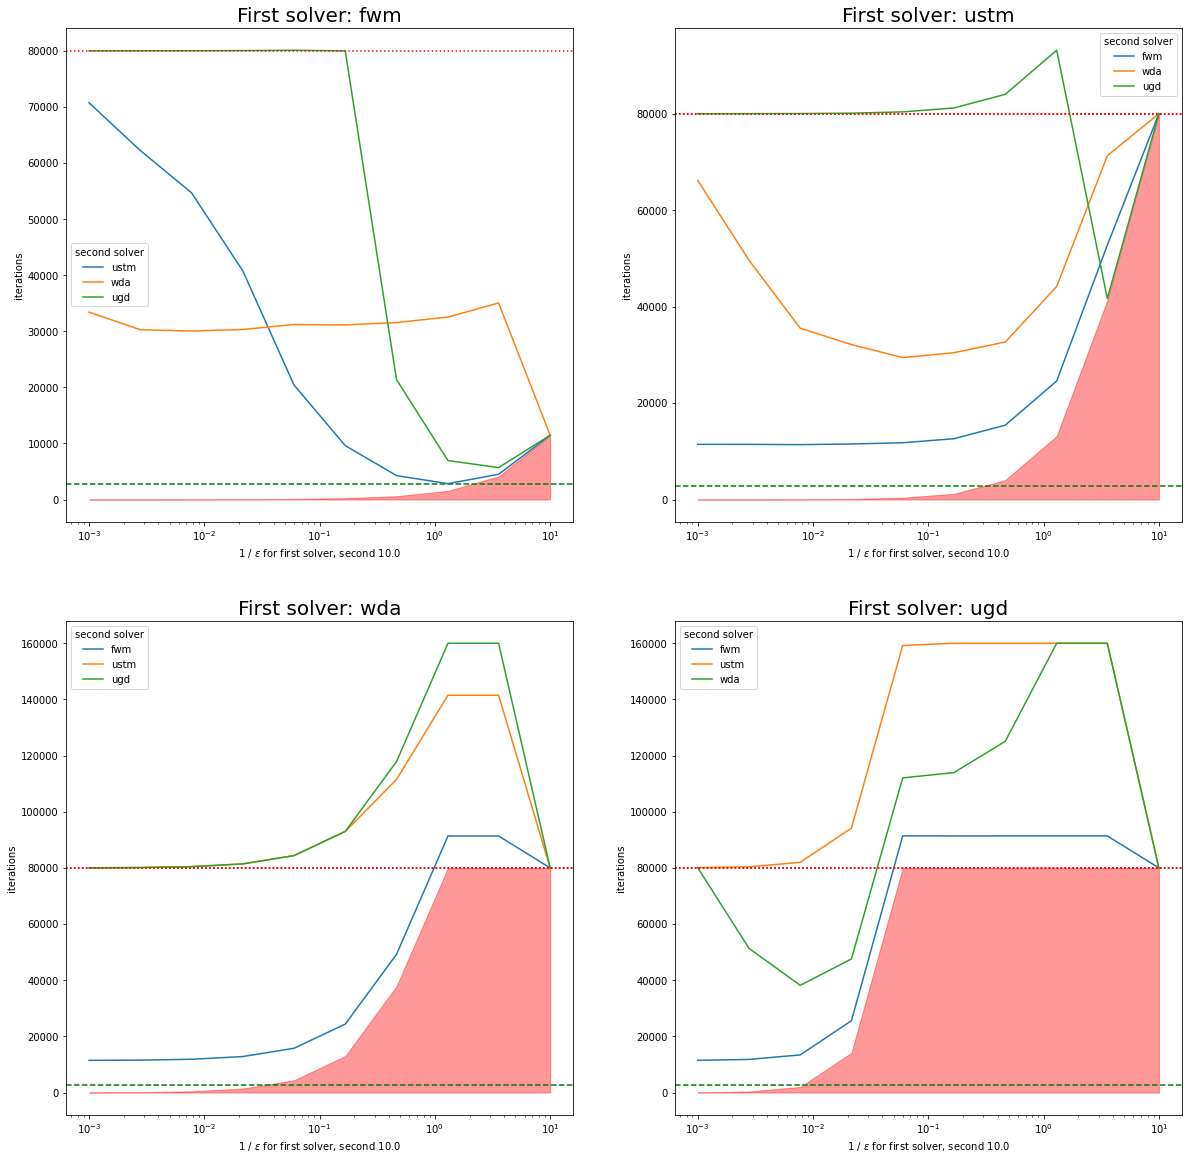

In [68]:
def draw_plot(first_solver, plot):
    plot.set_title('First solver: ' + first_solver, fontsize=20)
    plot.set_xlabel(r'1 / $\varepsilon$ for first solver, second ' + '{}'.format(1 /epsilons[-1]))
    plot.set_ylabel('iterations')
    plot.set_xscale('log')
    plot.axhline(y=min_iters, color='g', linestyle='--')
    plot.fill_between(1/epsilons, total_iters[first_solver]['self'], color='r', alpha=0.4)

    for second_solver in solvers:
        if second_solver == first_solver:
            continue
        y = total_iters[first_solver][second_solver]
        if len(y) == 2:
            plot.plot([1 / epsilons[-1], 1 / epsilons[0]], y, label = second_solver)
        else:
            plot.plot(1 / epsilons, y, label = second_solver)
        
        if (np.array(y).max() >= max_iter):
            plot.axhline(y=max_iter, color='r', linestyle=':')
        # plot.set_xticklabels(['']+[str(iters) + '+' + str (20000 - iters)for iters in x]+[''], rotation=-45)
        # plot.locator_params(axis='x', nbins=12)
        # plot.set_yscale('log')
    plot.legend(title = 'second solver')


fig, axs = plt.subplots(2, 2, figsize=(20.,20.))
draw_plot('fwm', axs[0][0])
draw_plot('ustm', axs[0][1])
draw_plot('wda', axs[1][0])
draw_plot('ugd', axs[1][1])
plt.show()